# Overview

    -Test/Train Split
    -Min Max Scaling 
    -Hyperparameter Estimation
    -Model Evaluation (Precision/Recall Curves)

# Load Libraries & Data

In [1]:
#General Imports
import glob, os
import pandas as pd
import numpy as np
import json
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Image
from scipy.stats import uniform
from datetime import datetime
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

In [2]:
#Sklearn imports
from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.svm import SVC
from sklearn.datasets import make_classification
from sklearn.metrics import plot_confusion_matrix, classification_report, \
roc_curve, plot_precision_recall_curve, precision_recall_curve, confusion_matrix, auc, plot_roc_curve
from sklearn.feature_selection import SelectFromModel

In [3]:
os.chdir("../src/data")
from time_elapsed import time_elapsed
from PlotPrecisionRecall import Plot_PR
from PlotFeatureImportance import Plot_Feat_Imp

In [4]:
os.chdir("../../src/data")
from PlotFeatureImportance import Plot_Feat_Imp

In [5]:
os.chdir("../../data/interim")

#Load in Data
#First, the notes
with open("Data_Notes.json", "r") as infile:  
    notes=json.load(infile)
    
os.chdir("../processed")
#Next, the actual data
df=pd.read_csv('sepsis_data_preprocessed.csv',index_col=0)

In [6]:
#Drop Unit/Hospital Identifying Variables
list_=['Unit1','Unit2','HospitalA']
df.drop(columns=list_,inplace=True)

In [63]:
#df_copy=df.copy()
df=df_copy

In [44]:
id_G_55=np.unique(df[df.ICULOS>24]['id'])
df_G_55=df[df.id.isin(id_G_55)].copy()
df=df_G_55

## Preventing Data Leakage in Train & Test Sets

In [64]:
#Generate matrix with all patient id's randomly shuffled (id_shuff)
np.random.seed(seed=5)
id_shuff=df.id.unique()
np.random.shuffle(id_shuff)
#Split into test & train arrays of 1/4 and 3/4 the original size
n=int(round(id_shuff.size*0.25,0))
test_id=id_shuff[0:n]
train_id=id_shuff[n:]

In [65]:
#Calculate percent of time points in test df
a=round(len(df[df.id.isin(test_id)])/(len(df))*100,2)
print("The test data set has {}% of the data points".format(a))

The test data set has 25.55% of the data points


In [66]:
#Calculate percent of patients with sepsis in train df 
a=round(df[df.id.isin(train_id)].SepsisOnset.sum()/len(train_id)*100,2)
print("{}% of patients in the train data set have sepsis".format(a))

7.63% of patients in the train data set have sepsis


In [67]:
#Calculate percent of patients with sepsis in test df 
a=round(df[df.id.isin(test_id)].SepsisOnset.sum()/len(test_id)*100,2)
print("{}% of patients in the test data set have sepsis".format(a))

7.74% of patients in the test data set have sepsis


In [61]:
train_id.shape

(3358,)

## Create Test & Train Sets

In [68]:
#Create Test/Train X
X_train=df[df.id.isin(train_id)].copy()
X_test=df[df.id.isin(test_id)].copy()

#Split y_train into various classification columns 
y_train_sepsis=X_train['SepsisLabel']
y_train_pre=X_train['Pre_Sepsis_Three']

#Split y_test into various classification columns 
y_test_sepsis=X_test['SepsisLabel']
y_test_pre=X_test['Pre_Sepsis_Three']

#Drop all classifiers from X
X_train.drop(columns=['SepsisLabel','SepsisOnset','id','Pre_Sepsis_Three'],inplace=True)
X_test.drop(columns=['SepsisLabel','SepsisOnset','id','Pre_Sepsis_Three'],inplace=True)

#Get Labels for later
Var_names=list(X_train.columns)

## Apply Min/Max Scaler, Ensure CV has No Cross Leakage

In [69]:
#Fit Min-Max Scaler to X_train data, transform X_train and X_test data
MM_scale=MinMaxScaler()
MM_scale.fit(X_train)
X_train=MM_scale.transform(X_train)
X_test=MM_scale.transform(X_test)

#Create kfolds CV objest (to allow for sequential folding, not random - prevents data leakage in cross folds)
folds=KFold(n_splits=4)

# Modeling Sepsis Label

## Dummy Classifier

In [14]:
#Model Sepsis Label - Dummy Classifier, Most Frequent
dummy_clf = DummyClassifier(strategy="most_frequent")
y_pred_dummy=dummy_clf.fit(X_train, y_train_sepsis).predict(X_test)
print(classification_report(y_test_sepsis,y_pred_dummy,zero_division=0))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99     57984
           1       0.00      0.00      0.00      1116

    accuracy                           0.98     59100
   macro avg       0.49      0.50      0.50     59100
weighted avg       0.96      0.98      0.97     59100



## Logistic Regression

### Sepsis Label - All

In [15]:
#Find logsitic regression parameters for modelling Sepsis Label
start = datetime.now()
clf = LogisticRegression(max_iter=10000)
C=[1/(10**i) for i in range(0,10)]
distributions = {'C': C}
LR_GS=GridSearchCV(clf,distributions,cv=folds.split(X_train),n_jobs=-1,scoring='f1')
search_LR_GS=LR_GS.fit(X_train, y_train_sepsis)
end = datetime.now()
time_elapsed(start,end)
best_dict=search_LR_GS.best_params_
search_LR_GS.best_params_

This process took 00 Hours 00 Minutes 51 Seconds 


{'C': 1.0}

In [16]:
#Make Logistic Regression Model with optimized C
clf=LogisticRegression(max_iter=1000,C=best_dict['C'])
clf.fit(X_train,y_train_sepsis)
clf.predict(X_test)

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [17]:
print(classification_report(y_test_sepsis,clf.predict(X_test),zero_division=1))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99     57984
           1       0.18      0.02      0.03      1116

    accuracy                           0.98     59100
   macro avg       0.58      0.51      0.51     59100
weighted avg       0.97      0.98      0.97     59100



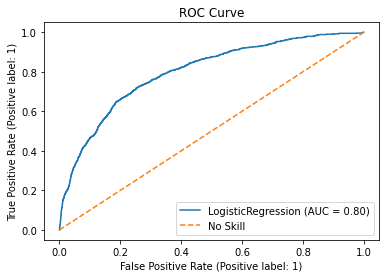

In [18]:
plot_roc_curve(clf,X_test,y_test_sepsis)
plt.plot([0,1],[0,1],label='No Skill',linestyle='--')
plt.legend()
plt.title('ROC Curve')
plt.show()

Best Train Threshold=0.101023, F-Score=0.172
Best Test Threshold=0.154520, F-Score=0.173
Train AUC: 0.097 Test AUC: 0.096


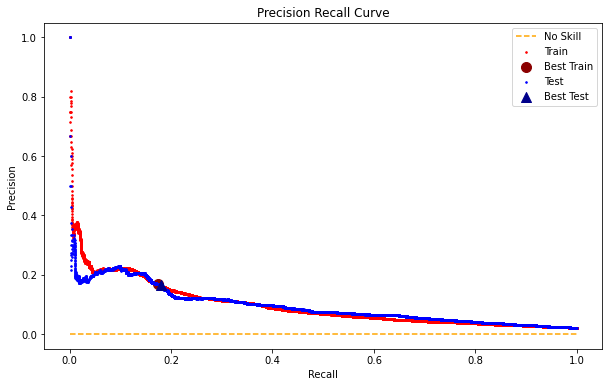

In [19]:
Plot_PR(clf,X_train,y_train_sepsis,X_test,y_test_sepsis,auc,precision_recall_curve,np,plt,(10,6))

### Sepsis Label - 50

In [32]:
#Find logsitic regression parameters for modelling Sepsis Label
start = datetime.now()
clf = LogisticRegression(max_iter=10000)
C=[1/(10**i) for i in range(0,10)]
distributions = {'C': C}
LR_GS=GridSearchCV(clf,distributions,cv=folds.split(X_train),n_jobs=-1,scoring='f1')
search_LR_GS=LR_GS.fit(X_train, y_train_sepsis)
end = datetime.now()
time_elapsed(start,end)
best_dict=search_LR_GS.best_params_
search_LR_GS.best_params_

This process took 00 Hours 01 Minutes 00 Seconds 


C:\Users\amcas\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


{'C': 1.0}

In [33]:
#Make Logistic Regression Model with optimized C
clf=LogisticRegression(max_iter=10000,C=best_dict['C'])
clf.fit(X_train,y_train_sepsis)
clf.predict(X_test)

C:\Users\amcas\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [34]:
print(classification_report(y_test_sepsis,clf.predict(X_test),zero_division=1))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99     17685
           1       0.32      0.02      0.04       445

    accuracy                           0.97     18130
   macro avg       0.65      0.51      0.51     18130
weighted avg       0.96      0.97      0.96     18130



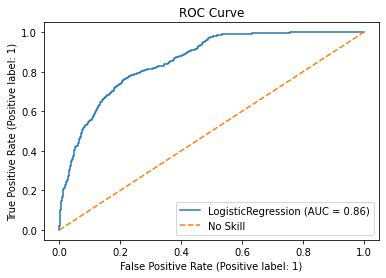

In [35]:
plot_roc_curve(clf,X_test,y_test_sepsis)
plt.plot([0,1],[0,1],label='No Skill',linestyle='--')
plt.legend()
plt.title('ROC Curve')
plt.show()

Best Train Threshold=0.676443, F-Score=nan
Best Test Threshold=0.249382, F-Score=0.241
Train AUC: 0.196 Test AUC: 0.178


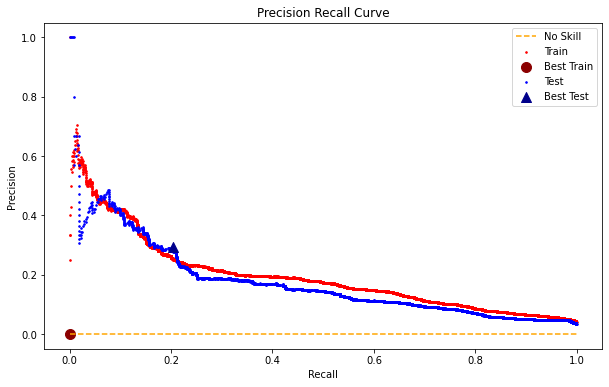

In [36]:
Plot_PR(clf,X_train,y_train_sepsis,X_test,y_test_sepsis,auc,precision_recall_curve,np,plt,(10,6))

### Sepsis Label - 55

In [ ]:
#Find logsitic regression parameters for modelling Sepsis Label
start = datetime.now()
clf = LogisticRegression(max_iter=1000)
C=[1/(10**i) for i in range(0,10)]
distributions = {'C': C}
LR_GS=GridSearchCV(clf,distributions,cv=folds.split(X_train),n_jobs=-1,scoring='f1')
search_LR_GS=LR_GS.fit(X_train, y_train_sepsis)
end = datetime.now()
time_elapsed(start,end)
best_dict=search_LR_GS.best_params_
search_LR_GS.best_params_

In [ ]:
#Make Logistic Regression Model with optimized C
clf=LogisticRegression(max_iter=1000,C=best_dict['C'])
clf.fit(X_train,y_train_sepsis)
clf.predict(X_test)

In [ ]:
print(classification_report(y_test_sepsis,clf.predict(X_test),zero_division=1))

In [ ]:
plot_roc_curve(clf,X_test,y_test_sepsis)
plt.plot([0,1],[0,1],label='No Skill',linestyle='--')
plt.legend()
plt.title('ROC Curve')
plt.show()

In [ ]:
Plot_PR(clf,X_train,y_train_sepsis,X_test,y_test_sepsis,auc,precision_recall_curve,np,plt,(10,6))

### Pre Sepsis - All

In [70]:
#Find logsitic regression parameters for modelling Sepsis Label
start = datetime.now()
clf = LogisticRegression(max_iter=10000)
C=[1/(10**i) for i in range(0,10)]
distributions = {'C': C}
LR_GS=GridSearchCV(clf,distributions,cv=folds.split(X_train),n_jobs=-1,scoring='f1')
search_LR_GS=LR_GS.fit(X_train, y_train_pre)
end = datetime.now()
time_elapsed(start,end)
best_dict=search_LR_GS.best_params_
search_LR_GS.best_params_

This process took 00 Hours 00 Minutes 39 Seconds 


{'C': 1.0}

In [71]:
#Make Logistic Regression Model with optimized C
clf=LogisticRegression(max_iter=1000,C=best_dict['C'])
clf.fit(X_train,y_train_pre)

LogisticRegression(max_iter=1000)

In [72]:
print(classification_report(y_test_pre,clf.predict(X_test),zero_division=1))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00     58797
           1       1.00      0.00      0.00       303

    accuracy                           0.99     59100
   macro avg       1.00      0.50      0.50     59100
weighted avg       0.99      0.99      0.99     59100



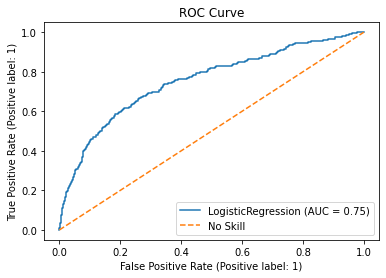

In [73]:
plot_roc_curve(clf,X_test,y_test_pre)
plt.plot([0,1],[0,1],label='No Skill',linestyle='--')
plt.legend()
plt.title('ROC Curve')
plt.show()

Best Train Threshold=0.146481, F-Score=nan
Best Test Threshold=0.270916, F-Score=nan
Train AUC: 0.025 Test AUC: 0.024


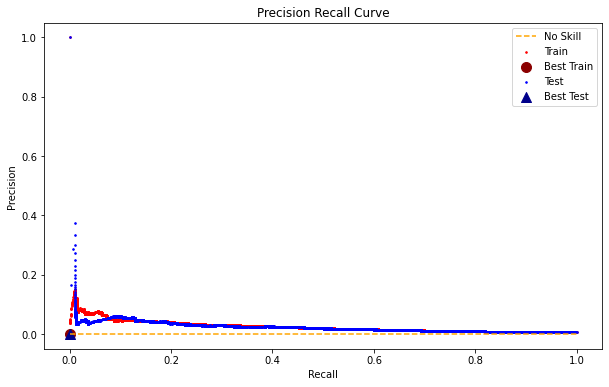

In [74]:
Plot_PR(clf,X_train,y_train_pre,X_test,y_test_pre,auc,precision_recall_curve,np,plt,(10,6))

### Sepsis Label - 50

In [32]:
#Find logsitic regression parameters for modelling Sepsis Label
start = datetime.now()
clf = LogisticRegression(max_iter=10000)
C=[1/(10**i) for i in range(0,10)]
distributions = {'C': C}
LR_GS=GridSearchCV(clf,distributions,cv=folds.split(X_train),n_jobs=-1,scoring='f1')
search_LR_GS=LR_GS.fit(X_train, y_train_pre)
end = datetime.now()
time_elapsed(start,end)
best_dict=search_LR_GS.best_params_
search_LR_GS.best_params_

This process took 00 Hours 01 Minutes 00 Seconds 


C:\Users\amcas\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


{'C': 1.0}

In [33]:
#Make Logistic Regression Model with optimized C
clf=LogisticRegression(max_iter=10000,C=best_dict['C'])
clf.fit(X_train,y_train_pre)
clf.predict(X_test)

C:\Users\amcas\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [34]:
print(classification_report(y_test_pre,clf.predict(X_test),zero_division=1))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99     17685
           1       0.32      0.02      0.04       445

    accuracy                           0.97     18130
   macro avg       0.65      0.51      0.51     18130
weighted avg       0.96      0.97      0.96     18130



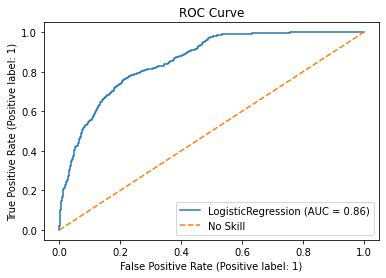

In [35]:
plot_roc_curve(clf,X_test,y_test_pre)
plt.plot([0,1],[0,1],label='No Skill',linestyle='--')
plt.legend()
plt.title('ROC Curve')
plt.show()

Best Train Threshold=0.676443, F-Score=nan
Best Test Threshold=0.249382, F-Score=0.241
Train AUC: 0.196 Test AUC: 0.178


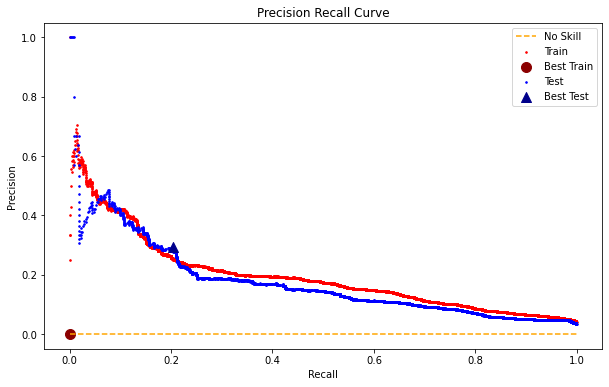

In [36]:
Plot_PR(clf,X_train,y_train_pre,X_test,y_test_pre,auc,precision_recall_curve,np,plt,(10,6))

### Sepsis Label - 55

In [ ]:
#Find logsitic regression parameters for modelling Sepsis Label
start = datetime.now()
clf = LogisticRegression(max_iter=1000)
C=[1/(10**i) for i in range(0,10)]
distributions = {'C': C}
LR_GS=GridSearchCV(clf,distributions,cv=folds.split(X_train),n_jobs=-1,scoring='f1')
search_LR_GS=LR_GS.fit(X_train, y_train_pre)
end = datetime.now()
time_elapsed(start,end)
best_dict=search_LR_GS.best_params_
search_LR_GS.best_params_

In [ ]:
#Make Logistic Regression Model with optimized C
clf=LogisticRegression(max_iter=1000,C=best_dict['C'])
clf.fit(X_train,y_train_pre)
clf.predict(X_test)

In [ ]:
print(classification_report(y_test_pre,clf.predict(X_test),zero_division=1))

In [ ]:
plot_roc_curve(clf,X_test,y_test_sepsis)
plt.plot([0,1],[0,1],label='No Skill',linestyle='--')
plt.legend()
plt.title('ROC Curve')
plt.show()

In [ ]:
Plot_PR(clf,X_train,y_train_pre,X_test,y_test_pre,auc,precision_recall_curve,np,plt,(10,6))

## Random Forest


In [ ]:
#Find optimal random forest parameters for modelling Sepsis Label
start = datetime.now()
RFC = RandomForestClassifier(random_state=42,max_features='sqrt',n_estimators=500)
max_depth = [x**2 for x in range(2,10)]
min_samples_split = [4,7,16]
min_samples_leaf = [4,7,16]
distributions = {'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}
RFC_RS=RandomizedSearchCV(RFC,distributions,random_state=42,n_iter=20,cv=folds.split(X_train),n_jobs=-1,scoring='f1')
search_RFC_Sepsis=RFC_RS.fit(X_train, y_train_pre)
end = datetime.now()
time_elapsed(start,end)
search_RFC_Sepsis.best_params_

In [ ]:
#best_dict=search_RFC_Sepsis.best_params_
best_dict={'min_samples_split': 7, 'min_samples_leaf': 7, 'max_depth': 4}

In [ ]:
#Create Model
RFC_=RandomForestClassifier(n_estimators=1000, min_samples_split=best_dict['min_samples_split'],
min_samples_leaf=best_dict['min_samples_leaf'], max_features='sqrt', max_depth=best_dict['max_depth'],
random_state=42,n_jobs=-1)
RFC_.fit(X_train,y_train_pre)

In [ ]:
print(classification_report(y_test_pre,RFC_.predict(X_test),zero_division=1))

In [ ]:
Plot_PR(RFC_,X_train,y_train_pre,X_test,y_test_pre,auc,precision_recall_curve,np,plt,(10,6))

In [ ]:
Plot_Feat_Imp(RFC_,Var_names,pd,np,plt,(12,8))

## Gradient Boost

In [ ]:
#Find optimal random forest parameters for modelling Pre Sep 2
start = datetime.now()
GB = GradientBoostingClassifier(random_state=42,max_features='sqrt',n_estimators=200)
max_depth = [3,7,12]
learning_rate=[0.001,0.01,0.1,0.25,1]
loss=['deviance', 'exponential']
distributions = {'max_depth': max_depth,'learning_rate': learning_rate,'loss': loss}
GB_RS=RandomizedSearchCV(GB,distributions,random_state=42,n_iter=10,cv=folds.split(X_train),n_jobs=-1,scoring='f1')
search_GB_Sepsis=GB_RS.fit(X_train,y_train_three)
end = datetime.now()
time_elapsed(start,end)
search_GB_Sepsis.best_params_

In [ ]:
best_dict=search_GB_Sepsis.best_params_

In [ ]:
importance = GB_.feature_importances_
importance = pd.DataFrame(importance, index=df_.columns, 
                          columns=["Importance"])

x = range(importance.shape[0])
y = importance.iloc[:, 0]
plt.subplots(figsize=(16,10))
plt.bar(x, y, align="center")
plt.xticks(ticks=range(0,91),labels=importance.index,rotation=90)
plt.show()

In [ ]:
search_GB_Sepsis.cv_results_

In [ ]:
best_dict={'max_depth': 4, 'loss': 'exponential', 'learning_rate': 0.1}

In [ ]:
#Create Model
start = datetime.now()
GB_=GradientBoostingClassifier(n_estimators=200, learning_rate=best_dict['learning_rate'],
loss=best_dict['loss'], max_features='sqrt', max_depth=best_dict['max_depth'], random_state=42)
#GB_.fit(X_train,y_train_pre_sep_2)
GB_.fit(X_train,y_train_three)
end = datetime.now()
time_elapsed(start,end)

In [ ]:
#Results for Training Set
yhat = GB_.predict_proba(X_train)
yhat = yhat[:, 1]
#precision, recall, thresholds = precision_recall_curve(y_train_pre_sep_2, yhat)
precision, recall, thresholds = precision_recall_curve(y_train_three, yhat)
fscore = (2 * precision * recall) / (precision + recall)
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f' % (thresholds[ix], fscore[ix]))
no_skill = len(y_train_sepsis[y_train_sepsis==1]) / len(y_train_sepsis)
auc_=round(auc(recall,precision),3)
plt.plot([0,1], [no_skill,no_skill], linestyle='--', label='No Skill',c='orange')
plt.scatter(recall, precision, marker='.', label='Random Forest',s=10)
plt.scatter(recall[ix], precision[ix], marker='o', color='black', label='Best',s=100)
plt.text(0, .25, 'AUC: {}'.format(auc_), style='italic',
        bbox={'facecolor': 'red', 'alpha': 0.5, 'pad': 10})
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Sepsis Label Training Data')
plt.legend()
# show the plot
plt.show()

In [ ]:
#Results for Test Set
yhat = GB_.predict_proba(X_test)
yhat = yhat[:, 1]
#precision, recall, thresholds = precision_recall_curve(y_test_pre_sep_2, yhat)
precision, recall, thresholds = precision_recall_curve(y_train_three, yhat)
fscore = (2 * precision * recall) / (precision + recall)
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f' % (thresholds[ix], fscore[ix]))
no_skill = len(y_test_sepsis[y_test_sepsis==1]) / len(y_test_sepsis)
auc_=round(auc(recall,precision),3)
plt.plot([0,1], [no_skill,no_skill], linestyle='--', label='No Skill',c='orange')
plt.scatter(recall, precision, marker='.', label='Random Forest',s=10)
plt.scatter(recall[ix], precision[ix], marker='o', color='black', label='Best',s=100)
plt.text(0, .25, 'AUC: {}'.format(auc_), style='italic',
        bbox={'facecolor': 'red', 'alpha': 0.5, 'pad': 10})
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Sepsis Label Test Data')
plt.legend()
# show the plot
plt.show()

In [ ]:
print(classification_report(y_test_pre_sep_2,GB_.predict(X_test)))

In [ ]:
#Find optimal random forest parameters for modelling Sepsis Label
"""start = datetime.now()
RFC = RandomForestClassifier(random_state=42,max_features='sqrt',n_estimators=500)
max_depth = [x**2 for x in range(2,10)]
min_samples_split = [4,7,16]
min_samples_leaf = [4,7,16]
distributions = {'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}
RFC_RS=RandomizedSearchCV(RFC,distributions,random_state=42,n_iter=20,cv=folds.split(X_train),n_jobs=-1)
search_RFC_Sepsis=RFC_RS.fit(X_train, y_train_sepsis)
end = datetime.now()
time_elapsed(start,end)
search_RFC_Sepsis.best_params_"""

In [ ]:
#best_dict=search_RFC_Sepsis.best_params_
best_dict={'min_samples_split': 7, 'min_samples_leaf': 7, 'max_depth': 4}

In [ ]:
#Create Model
start = datetime.now()
RFC_=RandomForestClassifier(n_estimators=2000, min_samples_split=best_dict['min_samples_split'],
min_samples_leaf=best_dict['min_samples_leaf'], max_features='sqrt', max_depth=best_dict['max_depth'],
random_state=42,n_jobs=-1)
RFC_.fit(X_train,y_train_pre_sep_3)
end = datetime.now()
time_elapsed(start,end)

In [ ]:
#Results for Training Set
yhat = RFC_.predict_proba(X_train)
yhat = yhat[:, 1]
precision, recall, thresholds = precision_recall_curve(y_train_pre_sep_2, yhat)
fscore = (2 * precision * recall) / (precision + recall)
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f' % (thresholds[ix], fscore[ix]))
no_skill = len(y_train_sepsis[y_train_sepsis==1]) / len(y_train_sepsis)
auc_=round(auc(recall,precision),3)
plt.plot([0,1], [no_skill,no_skill], linestyle='--', label='No Skill',c='orange')
plt.scatter(recall, precision, marker='.', label='Random Forest',s=10)
plt.scatter(recall[ix], precision[ix], marker='o', color='black', label='Best',s=100)
plt.text(0, .25, 'AUC: {}'.format(auc_), style='italic',
        bbox={'facecolor': 'red', 'alpha': 0.5, 'pad': 10})
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Sepsis Label Training Data')
plt.legend()
# show the plot
plt.show()

In [ ]:
print(classification_report(y_train_pre_sep_3,RFC_.predict(X_train)))

In [ ]:
#Results for Test Set
yhat = RFC_.predict_proba(X_test)
yhat = yhat[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test_pre_sep_3, yhat)
fscore = (2 * precision * recall) / (precision + recall)
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f' % (thresholds[ix], fscore[ix]))
no_skill = len(y_test_sepsis[y_test_sepsis==1]) / len(y_test_sepsis)
auc_=round(auc(recall,precision),3)
plt.plot([0,1], [no_skill,no_skill], linestyle='--', label='No Skill',c='orange')
plt.scatter(recall, precision, marker='.', label='Random Forest',s=10)
plt.scatter(recall[ix], precision[ix], marker='o', color='black', label='Best',s=100)
plt.text(0, .25, 'AUC: {}'.format(auc_), style='italic',
        bbox={'facecolor': 'red', 'alpha': 0.5, 'pad': 10})
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Sepsis Label Test Data')
plt.legend()
# show the plot
plt.show()

In [ ]:
RFC_.feature_importances_

In [ ]:
r=list(X_train.columns.values)
v=list(RFC_.feature_importances_)

In [ ]:
pd.DataFrame({'features':r,'values':v})

In [ ]:
len(importance.index)

In [ ]:
importance = RFC_.feature_importances_
importance = pd.DataFrame(importance, index=X_train.columns, 
                          columns=["Importance"])

importance["Std"] = np.std([tree.feature_importances_
                            for tree in RFC_.estimators_], axis=0)

x = range(importance.shape[0])
y = importance.iloc[:, 0]
yerr = importance.iloc[:, 1]
plt.subplots(figsize=(16,10))
plt.bar(x, y, yerr=yerr, align="center")
plt.xticks(ticks=range(0,91),labels=importance.index,rotation=90)
plt.show()

In [ ]:
importance.sort

# Smote

In [ ]:
#from imblearn.over_sampling import SMOTE
#smote=SMOTE(sampling_strategy='minority')
#X_train,y_train_three=smote.fit_resample(X_train,y_train_three)

# Cutting Patients ICULOS<50

In [ ]:
def sep_ICULOS(n):
    tot_pat=len(df[df.ICULOS>n]['id'].value_counts())
    sep=df[df.ICULOS>n]['SepsisOnset'].sum()
    ratio=round((sep/(tot_pat))*100,2)
    print("Total # of Patients: {}".format(tot_pat))
    print("Patients with Sepsis: {}".format(sep))
    print("Ratio: {}".format(ratio))

In [ ]:
sep_ICULOS(58)

In [ ]:
sep_ICULOS(55)

In [ ]:
sep_ICULOS(54)

In [ ]:
sep_ICULOS(53)

In [ ]:
sep_ICULOS(52)

In [ ]:
sep_ICULOS(51)

In [ ]:
sep_ICULOS(60)